# Diversity vs. Similarity at the State Level

This notebook compares diversity and segregation at the state level.

# 0. Imports and configuration

In [1]:
import censusdis.data as ced
import censusdis.maps as cem
from censusdis import states

import divintseg as dis

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import itertools

In [2]:
# Fill in your own key here, or leave as is
# if you are doing low volume queries that
# will not hit the census server usage limits.
CENSUS_API_KEY = None

# 1. Identify the dataset and variables we will use

In [3]:
DATASET = "acs/acs5"
YEAR = 2020

In [4]:
GROUP = "B03002"

HISPANIC_LATINO_VARIABLE = f'{GROUP}_012E'

In [5]:
df_variables = ced.variables.all_variables(DATASET, YEAR, GROUP)
df_variables

,YEAR,DATASET,GROUP,VARIABLE,LABEL,SUGGESTED_WEIGHT,VALUES
0,2020,acs/acs5,B03002,B03002_001E,Estimate!!Total:,NaN,None
1,2020,acs/acs5,B03002,B03002_002E,Estimate!!Total:!!Not Hispanic or Latino:,NaN,None
2,2020,acs/acs5,B03002,B03002_003E,Estimate!!Total:!!Not Hispanic or Latino:!!Whi...,NaN,None
3,2020,acs/acs5,B03002,B03002_004E,Estimate!!Total:!!Not Hispanic or Latino:!!Bla...,NaN,None
4,2020,acs/acs5,B03002,B03002_005E,Estimate!!Total:!!Not Hispanic or Latino:!!Ame...,NaN,None
5,2020,acs/acs5,B03002,B03002_006E,Estimate!!Total:!!Not Hispanic or Latino:!!Asi...,NaN,None
6,2020,acs/acs5,B03002,B03002_007E,Estimate!!Total:!!Not Hispanic or Latino:!!Nat...,NaN,None
7,2020,acs/acs5,B03002,B03002_008E,Estimate!!Total:!!Not Hispanic or Latino:!!Som...,NaN,None
8,2020,acs/acs5,B03002,B03002_009E,Estimate!!Total:!!Not Hispanic or Latino:!!Two...,NaN,None
9,2020,acs/acs5,B03002,B03002_010E,Estimate!!Total:!!Not Hispanic or Latino:!!Two...,NaN,None


In [6]:
group_leaves = ced.variables.group_leaves(DATASET, YEAR, GROUP)

In [7]:
# Leaves of the group if we prune the tree at 
# HISPANIC_LATINO_VARIABLE and don't go down 
# that side of the tree.
race_or_hl_leaves = (
    [leaf for leaf in group_leaves if leaf < HISPANIC_LATINO_VARIABLE] + 
    [HISPANIC_LATINO_VARIABLE]
)

Now we can decide which set of variables we want as leaves. 
Uncomment one or the other.

In [8]:
#leaves = group_leaves
leaves = race_or_hl_leaves

leaves

['B03002_003E',
 'B03002_004E',
 'B03002_005E',
 'B03002_006E',
 'B03002_007E',
 'B03002_008E',
 'B03002_010E',
 'B03002_011E',
 'B03002_012E']

In [9]:
leaf_names = {
    leaf: df_variables[df_variables['VARIABLE'] == leaf]['LABEL'].iloc[0].split('!!')[-1].split(':')[0]
    for leaf in leaves
}

leaf_names

{'B03002_003E': 'White alone',
 'B03002_004E': 'Black or African American alone',
 'B03002_005E': 'American Indian and Alaska Native alone',
 'B03002_006E': 'Asian alone',
 'B03002_007E': 'Native Hawaiian and Other Pacific Islander alone',
 'B03002_008E': 'Some other race alone',
 'B03002_010E': 'Two races including Some other race',
 'B03002_011E': 'Two races excluding Some other race, and three or more races',
 'B03002_012E': 'Hispanic or Latino'}

# 2. Download the data

In [16]:
def download_state(state: str):
    df_state = ced.download(
        DATASET,
        YEAR,
        ['NAME'] + leaves,
        state=state,
        api_key=CENSUS_API_KEY,
    )

    return df_state 
    
def download_tracts(state: str):
    df_tract = ced.download(
        DATASET,
        YEAR,
        ['NAME'] + leaves,
        state=state,
        tract="*",
        api_key=CENSUS_API_KEY,
    )
    
    # Drop tracts with tiny population.
    df_tract = df_tract[df_tract[leaves].sum(axis='columns') >= 100].copy()

    return df_tract

In [18]:
df_vt = download_state(states.VT)
df_vt.shape

(1, 11)

In [21]:
# Statewide white fraction.
float(df_vt['B03002_003E'] / df_vt[leaves].sum(axis='columns'))

0.9235368549187942

In [19]:
df_vt_tracts = download_tracts(states.VT)
df_vt_tracts.shape

(192, 13)

In [41]:
df_nj = download_state(states.NJ)
df_nj_tracts = download_tracts(states.NJ)

In [23]:
def add_frac_cols(df):
    df['total'] = df[leaves].sum(axis='columns')

    for leaf in leaves:
        df[f'frac_{leaf}'] = df[leaf] / df['total']
        
    return df

In [25]:
df_vt = add_frac_cols(df_vt)
df_vt[[f'frac_{leaf}' for leaf in leaves]]

,frac_B03002_003E,frac_B03002_004E,frac_B03002_005E,frac_B03002_006E,frac_B03002_007E,frac_B03002_008E,frac_B03002_010E,frac_B03002_011E,frac_B03002_012E
0,0.923537,0.012006,0.002463,0.016084,0.000308,0.001557,0.002555,0.02144,0.02005


In [26]:
df_vt_tracts = add_frac_cols(df_vt_tracts)

In [28]:
df_vt_tracts['max_col'] = df_vt_tracts[leaves].idxmax(axis='columns')

In [29]:
df_vt_tracts.columns

Index(['STATE', 'COUNTY', 'TRACT', 'NAME', 'B03002_003E', 'B03002_004E',
       'B03002_005E', 'B03002_006E', 'B03002_007E', 'B03002_008E',
       'B03002_010E', 'B03002_011E', 'B03002_012E', 'total',
       'frac_B03002_003E', 'frac_B03002_004E', 'frac_B03002_005E',
       'frac_B03002_006E', 'frac_B03002_007E', 'frac_B03002_008E',
       'frac_B03002_010E', 'frac_B03002_011E', 'frac_B03002_012E', 'max_col'],
      dtype='object')

In [42]:
df_nj_tracts = add_frac_cols(df_nj_tracts)

# 3. Compute Similarity and Diversity

In [44]:
dissim_vt = dis.dissimilarity(
    df_communities=df_vt_tracts[leaves],
    reference=df_vt[leaves]
)

In [45]:
df_vt_tracts['dissimilarity'] = dissim_vt
df_vt_tracts['similarity'] = 1 - dissim_vt

In [32]:
df_vt_tracts.head()

,STATE,COUNTY,TRACT,NAME,B03002_003E,B03002_004E,B03002_005E,B03002_006E,B03002_007E,B03002_008E,...,frac_B03002_005E,frac_B03002_006E,frac_B03002_007E,frac_B03002_008E,frac_B03002_010E,frac_B03002_011E,frac_B03002_012E,max_col,dissimilarity,similarity
0,50,027,965902,"Census Tract 9659.02, Windsor County, Vermont",1622,0,0,6,0,0,...,0.000000,0.003608,0.0,0.00000,0.000000,0.007817,0.013229,B03002_003E,0.051809,0.948191
1,50,027,966000,"Census Tract 9660, Windsor County, Vermont",3249,12,0,0,0,11,...,0.000000,0.000000,0.0,0.00328,0.000000,0.008646,0.015802,B03002_003E,0.046880,0.953120
2,50,027,966100,"Census Tract 9661, Windsor County, Vermont",2484,36,0,0,0,0,...,0.000000,0.000000,0.0,0.00000,0.000000,0.070803,0.009489,B03002_003E,0.050495,0.949505
3,50,027,966200,"Census Tract 9662, Windsor County, Vermont",1564,3,0,0,0,0,...,0.000000,0.000000,0.0,0.00000,0.001859,0.003717,0.023544,B03002_003E,0.048978,0.951022
4,50,027,966300,"Census Tract 9663, Windsor County, Vermont",1579,1,6,4,0,0,...,0.003392,0.002261,0.0,0.00000,0.000000,0.037309,0.063878,B03002_003E,0.060625,0.939375


In [50]:
diversity_vt = dis.diversity(df_vt_tracts[leaves])
df_vt_tracts['diversity'] = diversity_vt

In [47]:
dissim_nj = dis.dissimilarity(
    df_communities=df_nj_tracts[leaves],
    reference=df_nj[leaves]
)

In [48]:
df_nj_tracts['dissimilarity'] = dissim_nj
df_nj_tracts['similarity'] = 1 - dissim_nj

In [51]:
diversity_nj = dis.diversity(df_nj_tracts[leaves])
df_nj_tracts['diversity'] = diversity_nj

# 4. Calder Plots

## Helper Functions for Plotting

In [66]:
def scatter_state(df_tract, state: str, color='lightgrey', ax=None):
    ax = df_tract.plot.scatter(
        'similarity', 'diversity', s=0.2, c=color,
        ax=ax,
        figsize=(10, 8),
        label=f'All Tracts With at Least 100 Residents in {states.ABBREVIATIONS_FROM_IDS[state]} (n = {len(df_tract.index):,.0f})',
    )

    legend = ax.legend()
    for handle in legend.legend_handles:
        handle._sizes = [25]
    
    ax.set_xlim(-0.02, 1.02)
    ax.set_ylim(-0.02, 1.02)
    ax.grid()
    
    ax.xaxis.set_major_formatter(PercentFormatter(1.0))
    ax.yaxis.set_major_formatter(PercentFormatter(1.0))
    
    ax.set_xlabel("Similarity of Tracts to the State", fontsize=14)
    ax.set_ylabel("Tract Diversity", fontsize=14)
    
    ax.tick_params(axis='both', which='major', labelsize=12)

    return ax


def first_row_name(df):
    name = df['NAME'].iloc[0]
    name = (
        f'{name}\n'
        f'{100 * df["similarity"].iloc[0]:.1f}% similarity; '
        f'{100 * df["diversity"].iloc[0]:.1f}% diversity; '
    )
    
    return name


def plot_hilight(df, ax, color):

    name = first_row_name(df)

    df.plot.scatter(
        'similarity', 'diversity',
        s=50, c='#0000', edgecolor=color, linewidth=2,
        label=name,
        ax=ax
    )
    
    ax.set_xlabel("Similarity of Tracts to the State", fontsize=14)
    ax.set_ylabel("Tract Diversity", fontsize=14)


def plot_bar_selected(df_selected_points):

    df_selected_points['label'] = df_selected_points['NAME'].apply(
        lambda name: name.replace(',', '\n', 1).replace(',', ',\n').replace('Census Tract ', 'Tract ').replace(
            ' Municipality', '\nMunicipality'
        ).replace(
            ' County', '\nCounty'
        )
    )
    df_selected_points = df_selected_points.set_index('label')
    df_selected_points = df_selected_points[[f'frac_{leaf}' for leaf in leaves]].rename(
        {
            f'frac_{leaf}': f'Percent {leaf_names[leaf]}'
            for leaf in leaves
        },
        axis='columns'
    )
    
    ax = df_selected_points.plot.bar(
        figsize=(12, 6),
    )
    ax.grid(axis='y', color='lightgrey')
    plt.xticks(rotation=0)
    ax.set_xlabel(None)
    
    ax.yaxis.set_major_formatter(PercentFormatter(1.0))

    ax.tick_params(axis='both', which='major', labelsize=12)
    
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=2)
    
    ax.vlines([0.5, 1.5], 0, 1, colors='darkgrey', linestyle='solid')
    
    ax.set_ylim(0, 1)
    return ax

## All Tracts

A scatter plot of diversity vs. similarity for all census tracts with a population
of 100+ in the U.S.

The shape is a bit unusual. It looks to me like it could be the profile of a sculpture 
by Alexander Calder. So I nickname this kind of plot a *Calder plot*.

Text(0.5, 1.0, 'Tract Diversity and Similarity to the State Overall')

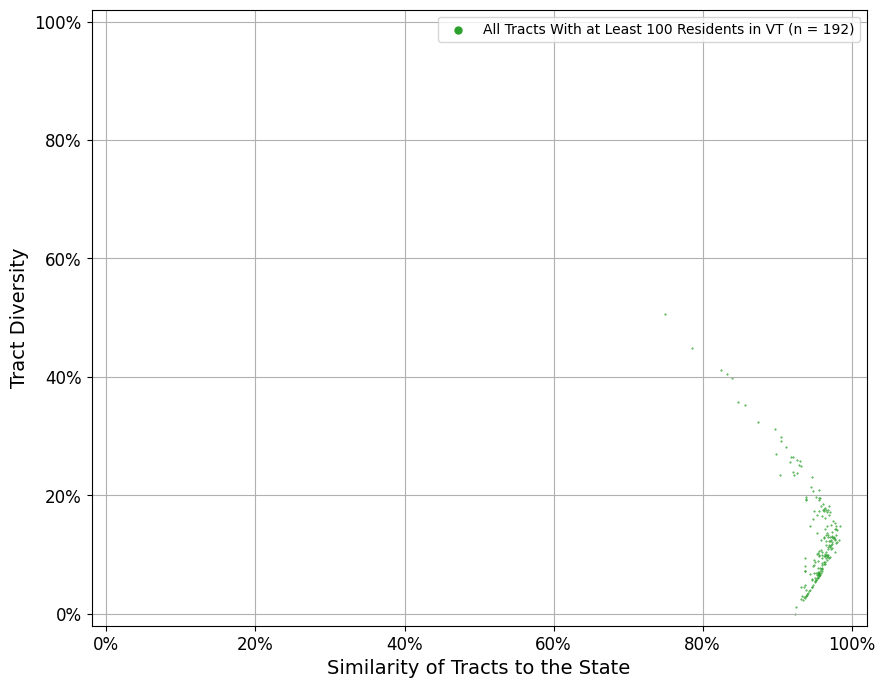

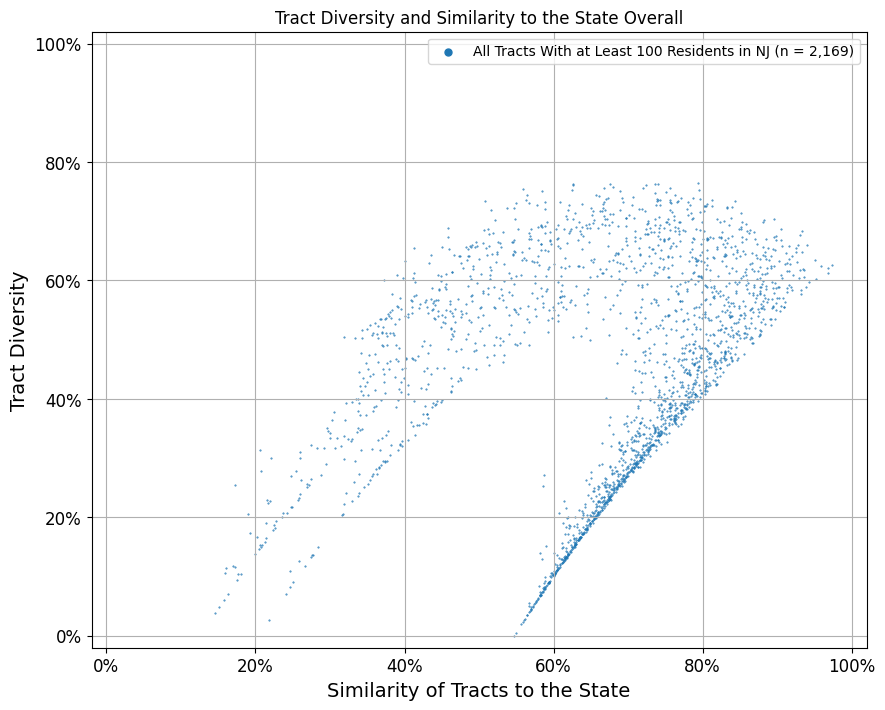

In [68]:
ax = scatter_state(df_vt_tracts, state=states.VT, color='C2')
ax = scatter_state(df_nj_tracts, state=states.NJ, color='C0')

ax.set_title("Tract Diversity and Similarity to the State Overall")